# Overview

The datafile taken is a time-series data that consists of flight details from MAA (Madras Airport) to DXB (Dubai, United Arab Emirates) of the year 2021. It contains 768 samples and 31 feature columns.

The purpose of this notebook file is to determine if the dataset is stationary or not stationary. Data preprocessing is done. Several tests are done on the dataset to analyze its stationarity. The tests done are :
- Rolling Statistics Test
- Augmented Dickey-Fuller (ADF) Test
- Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
- Zivot-Andrews Test

### 1- What is a time series data?
A time series dataset is a dataset that tracks the movement of data points over a period of time, recorded at regular intervals.

### 2- What is data stationary?
Stationarity is an important concept in the field of time series analysis with tremendous influence on how the data is perceived and predicted. Time series data are said to be stationary if they do not have any seasonal effects or any trends. A stationary data has the property that the mean, variance and autocorrelation remains almost the same over various time intervals.

In the dataset we have used, when the dataset is split into two parts and comparision of the mean and variance is done to check for stationarity, the mean is around 29.1875 and variance is around 650. So, in this case the dataset is stationary.

### 3- Why is data stationary necessary for forecasting?
When forecasting or predicting the future, most time series models assume that each point is independent of one another. Therefore, a stationary time series data is necessary for forecasting in order to obtain acceptable results.

### 4- What will happen if data is not stationary?
Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture. Therefore, the data cannot be forecasted using traditional time series models if the data is not stationary.

### 5- How to ensure whether the given data is stationary?
There are some methods to check whether a time series data is stationary or non-stationary.

- Graph : A plot can be made on the data and visually checked if there are any obvious trends or seasonality.

- Statistical Summary : Statistical measures like mean, variance and autocorrelation are measured for different periods of interval. If the corresponding measures for the different time intervals are neareer to each other (with some considered significance level) then the data is stationary else it is a non-stationary data.

- Statistical Tests : There are some statistical tests to check for stationarity on the data. Common tests used are also followed for this dataset such as :
 - Augmented Dickey-Fuller (ADF) Test
 - Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
 - Zivot-Andrews Test

### 6- How much data (volume of data) do we need for stationary?
Now we know that in order to check for stationarity in the data, the statistical summary (mean, variance, autocorrelation) should be nearer for different time intervals. Therefore, the data should be sufficient enough to be split into different time intervals.

Dataset from the same interval of time would obviously will be stationary since the time is constant (or almost constant) in this case.

### 7- List the steps involved to check whether the data is stationary?
- Performing visual interpretation on the dataset as mentioned above.
- Performing statistical comparisions as mentioned above.
- Performing various statistical test on the dependent feature involves,
 - Setting up the null hypothesis and alternate hypothesis.
 - Test results (p-value) are compared with necessary significant levels (critical levels) to decide whether to reject the null hypothesis or not.
 - Finally, the acceptance or rejection of null hypothesis (or alternate hypothesis) answers whether the data is stationary or not.

***Author : DeepSphere.AI***

# Import Libraries and Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install statsmodels --upgrade
!pip install openpyxl==3.0.0

     |████████████████████████████████| 9.8 MB 7.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 172 kB 8.3 MB/s 
  Created wheel for openpyxl: filename=openpyxl-3.0.0-py2.py3-none-any.whl size=241207 sha256=b1fb76c4ebb382ba9358d992d54407e4016b33a307712469ba5be707edb3adc2
  Stored in directory: /root/.cache/pip/wheels/c7/64/ff/ce98f6e1d2701ae8e216c875da62feed2839ac8a3cae0ab8af
Successfully built openpyxl
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import zivot_andrews

# Import Dataset

In [ ]:
dataset = pd.read_excel("/content/drive/MyDrive/FlyDubai-Base Data DP_v6 (1).xlsx")
dataset

,DATA CATEGORY,DATA SOURCE,MODEL NAME,TRAVEL DATE,YEAR,QUARTER,MONTH,WEEK,DAY,HOUR,REGION,ORGIN,DESTINATION,FLIGHT,CAPACITY,PRICE TYPE,PROMOTION,ROUNDTRIP OR ONEWAY,CUSTOMER TYPE,PRODUCT TYPE,LOCATION LIFESTYLE,LOCATION ECONOMICAL STATUS,LOCATION EMPLOYMENT STATUS,LOCATION EVENT,SOURCE WIND,SOURCE HUMIDITY,SOURCE PRECIPITATION,DESTINATION WIND,SOURCE HUMIDITY.1,DESTINATION PRECIPITATION,NUMBER OF BOOKING
0,ACTUAL,ETL,NaN,103202106,2021,Q1,JAN,1,SUNDAY,6,ASIA,MAA,DXB,FD101,467,DISCOUNT FARE,PROMO CODE,ROUNDTRIP,BUSINESS TRAVEL,FIRST CLASS,Individualistic,HIGH,EMPLOYED,CHRISTMAS,0.45 MPS,30%,RAIN,0.52 MPS,0.2,DRIZZLE,5
1,ACTUAL,ETL,NaN,103202106,2021,Q1,JAN,1,SUNDAY,6,ASIA,MAA,DXB,FD101,467,DISCOUNT FARE,PROMO CODE,ROUNDTRIP,FREQUENT FLYER,FIRST CLASS,Individualistic,HIGH,EMPLOYED,CHRISTMAS,0.45 MPS,30%,RAIN,0.52 MPS,0.2,DRIZZLE,10
2,ACTUAL,ETL,NaN,103202106,2021,Q1,JAN,1,SUNDAY,6,ASIA,MAA,DXB,FD101,467,DISCOUNT FARE,PROMO CODE,ROUNDTRIP,FIRST TIME FLYER,FIRST CLASS,Individualistic,HIGH,EMPLOYED,CHRISTMAS,0.45 MPS,30%,RAIN,0.52 MPS,0.2,DRIZZLE,5
3,ACTUAL,ETL,NaN,103202106,2021,Q1,JAN,1,SUNDAY,6,ASIA,MAA,DXB,FD101,467,DISCOUNT FARE,PROMO CODE,ROUNDTRIP,RARE FLYER,FIRST CLASS,Individualistic,HIGH,EMPLOYED,CHRISTMAS,0.45 MPS,30%,RAIN,0.52 MPS,0.2,DRIZZLE,5
4,ACTUAL,ETL,NaN,103202106,2021,Q1,JAN,1,SUNDAY,6,ASIA,MAA,DXB,FD102,467,DISCOUNT FARE,PROMO CODE,ROUNDTRIP,BUSINESS TRAVEL,BUSINESS CLASS,Individualistic,HIGH,EMPLOYED,CHRISTMAS,0.45 MPS,30%,RAIN,0.52 MPS,0.2,DRIZZLE,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,ACTUAL,ETL,NaN,329202124,2021,Q1,MAR,4,FRIDAY,24,ASIA,MAA,DXB,FD101,467,DISCOUNT FARE,PROMO CODE,ROUNDTRIP,RARE FLYER,ECONOMY PLUS,Individualistic,HIGH,EMPLOYED,CHRISTMAS,0.45 MPS,30%,RAIN,0.52 MPS,0.2,DRIZZLE,30
764,ACTUAL,ETL,NaN,329202124,2021,Q1,MAR,4,FRIDAY,24,ASIA,MAA,DXB,FD102,467,DISCOUNT FARE,PROMO CODE,ROUNDTRIP,BUSINESS TRAVEL,ECONOMY,Individualistic,HIGH,EMPLOYED,CHRISTMAS,0.45 MPS,30%,RAIN,0.52 MPS,0.2,DRIZZLE,75
765,ACTUAL,ETL,NaN,329202124,2021,Q1,MAR,4,FRIDAY,24,ASIA,MAA,DXB,FD102,467,DISCOUNT FARE,PROMO CODE,ROUNDTRIP,FREQUENT FLYER,ECONOMY,Individualistic,HIGH,EMPLOYED,CHRISTMAS,0.45 MPS,30%,RAIN,0.52 MPS,0.2,DRIZZLE,63
766,ACTUAL,ETL,NaN,329202124,2021,Q1,MAR,4,FRIDAY,24,ASIA,MAA,DXB,FD102,467,DISCOUNT FARE,PROMO CODE,ROUNDTRIP,FIRST TIME FLYER,ECONOMY,Individualistic,HIGH,EMPLOYED,CHRISTMAS,0.45 MPS,30%,RAIN,0.52 MPS,0.2,DRIZZLE,63


# Function to convert date to suitable format

In [ ]:
def convert_to_date(x):
  #Travel Date represents the Date of the flight operation. Ex: 322202124 (MM-DD-YYYY: HH)
  day = format(int(x[1:3]), "02d")
  month = format(int(x[0]), "02d")
  year = '-2021 '
  hour = format(int(x[-2:]),"02d")

  date_string = day + '-' + month + year + hour
  return date_string

# Class TimeSeriesData

In [ ]:
class TimeSeriesData:

  def __init__(self, dataset): #constructor
    #dataset - time series dataset
    self.dataset = dataset
    self.null_columns = self.dataset.columns[self.dataset.isna().any()].tolist() #contains null columns in the dataset
    self.constant_column = self.dataset.columns[self.dataset.nunique()==1].tolist() #contains constant columns in the dataset
    self.customer_type = {'BUSINESS TRAVEL':4, 'FREQUENT FLYER':3, 'FIRST TIME FLYER':1, 'RARE FLYER':2} #ordinality of customer type column
    self.travel_class = {'FIRST CLASS':4, 'BUSINESS CLASS':3, 'ECONOMY PLUS':2, 'ECONOMY':1} #ordinality of travel class column

  def display_columns(self): #display columns present in the dataset
    print(self.dataset.columns)

  def display_samples(self, random_state=42): #display random samples from the dataset
    display(self.dataset.sample(10, random_state=random_state))

  def drop_columns(self, columns): # drop columns from the dataset inplace
    # columns - list of columns to drop from the dataset
    self.dataset.drop(columns, axis=1, inplace=True)

  def convert_date_to_suitable_format(self): #convert date to convienient format
    # Travel Date represents the Date of the flight operation. Ex: 322202124 (MM-DD-YYYY: HH)
    self.dataset['TRAVEL DATE'] = self.dataset['TRAVEL DATE'].astype(str)
    self.dataset['TRAVEL DATE'] = self.dataset['TRAVEL DATE'].apply(convert_to_date)

  def encode_customer_type(self): #Converting the categorical column 'CUSTOMER TYPE' to ordinal values.
    self.dataset.replace({'CUSTOMER TYPE': self.customer_type}, inplace=True)

  def encode_product_type(self): #Converting the categorical column 'PRODUCT TYPE' to ordinal values.
    self.dataset.replace({'PRODUCT TYPE ': self.travel_class}, inplace=True)

  def encode_flight_column(self): #Encoding 'FLIGHT' column using one hot encoding.
    encoder = OneHotEncoder(sparse=True)
    encoder.fit(self.dataset[['FLIGHT']])

    encoded_values = encoder.transform(self.dataset[['FLIGHT']]).toarray()
    categories = list(encoder.categories_[0])

    self.dataset[categories] = encoded_values
    self.dataset.drop('FLIGHT', axis=1, inplace=True)

  def day_encoding(self): #Encoding 'DAY' column using one hot encoding.
    encoder = OneHotEncoder(sparse=True)
    encoder.fit(self.dataset[['DAY']])

    encoded_values = encoder.transform(self.dataset[['DAY']]).toarray()
    categories = list(encoder.categories_[0])

    self.dataset[categories] = encoded_values
    self.dataset.drop('DAY', axis=1, inplace=True)

  def graphical_analysis(self): #analyse the stationarity by histogram
    self.dataset[['NUMBER OF BOOKING']].hist()

  def mean_variance_stationary_analysis(self):
    # Splitting the time series data into two contiguous sequence and calculating mean and variance to compare the means and variances of the two sequence.

    # X - target feature 'NUMBER OF BOOKING'
    X = self.dataset[['NUMBER OF BOOKING']].values
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]

    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print("Mean :",mean1, mean2)
    print("Variance :", var1, var2)

  def rolling_statistics_test(self):
    # Function to give a visual representation of the data to define its stationarity.

    # X - target feature 'NUMBER OF BOOKING'
    X = self.dataset['NUMBER OF BOOKING']

    rolling_mean = X.rolling(window=12).mean()
    rolling_std = X.rolling(window=12).std()
    plt.figure(figsize=(20,8))
    orignal_data = plt.plot(X , color='black', label='Original') #original data
    roll_mean_plot = plt.plot(rolling_mean , color='red', label='Rolling Mean')  #rolling mean
    roll_std_plot = plt.plot(rolling_std, color='blue', label = 'Rolling Standard Deviation')  #rolling SD
    plt.legend(loc='best')
    plt.title("Rolling mean and Standard Deviation")
    plt.show(block=False)

  def augmented_dickey_fuller_test(self):
    #The Augmented Dickey-Fuller test is one of the more widely used type of statistical test (called a unit root test)
    #that it determines how strongly a time series is defined by a trend.

    # X - target feature 'NUMBER OF BOOKING'
    X = self.dataset['NUMBER OF BOOKING']
    adf_test_result = adfuller(X)
    print(f'ADF Statistic: {adf_test_result[0]}')
    print(f'p-value: {adf_test_result[1]}')

    for key, value in adf_test_result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

  def kwiatkowski_phillips_schmidt_shin_test(self):
    # The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test figures out if a time series is stationary around
    # a mean or linear trend, or is non-stationary due to a unit root.

    # X - target feature 'NUMBER OF BOOKING'
    X = self.dataset['NUMBER OF BOOKING']
    print ('Results of KPSS Test:')
    kpss_test = kpss(X, regression='c')
    kpss_test_output = pd.Series(kpss_test[0:3], index=['Test Statistic','p-value','#Lags Used'])

    for key,value in kpss_test[3].items():
        kpss_test_output['Critical Value (%s)'%key] = value
    print (kpss_test_output)

  def zivot_andrews_test(self):
    # X - target feature 'NUMBER OF BOOKING'
    X = self.dataset['NUMBER OF BOOKING']
    t_stat, p_value, critical_values, _, _ = zivot_andrews(X)
    print(f'Zivot-Andrews Statistic: {t_stat:.2f}')

    for key, value in critical_values.items():
        print('Critial Values:')
        print(f'   {key}, {value:.2f}')

    print(f'\np-value: {p_value:.2f}')
    print("Non-Stationary") if p_value > 0.05 else print("Stationary")

In [ ]:
time_series_data = TimeSeriesData(dataset)

# Preprocessing

## Remove All NULL Column

Some column(s) contains only null values in all samples. Those columns are to be removed since they provide no use.

In [ ]:
time_series_data.drop_columns(time_series_data.null_columns)
time_series_data.display_columns()

Index(['DATA CATEGORY', 'DATA SOURCE', 'TRAVEL DATE', 'YEAR', 'QUARTER',
       'MONTH', 'WEEK', 'DAY', ' HOUR', 'REGION', 'ORGIN ', 'DESTINATION',
       'FLIGHT', 'CAPACITY', 'PRICE TYPE', 'PROMOTION', 'ROUNDTRIP OR ONEWAY',
       'CUSTOMER TYPE', 'PRODUCT TYPE ', 'LOCATION LIFESTYLE ',
       'LOCATION ECONOMICAL STATUS ', 'LOCATION EMPLOYMENT STATUS',
       'LOCATION EVENT ', 'SOURCE WIND', 'SOURCE HUMIDITY',
       'SOURCE PRECIPITATION', 'DESTINATION WIND', 'SOURCE HUMIDITY.1',
       'DESTINATION PRECIPITATION', 'NUMBER OF BOOKING'],
      dtype='object')


## Remove Constant Columns

There are some features whose values are costant which are of no use. Some consider removing those feature. The constant features with the constant values are listed below.

- 'DATA CATEGORY' - ACTUAL
- 'DATA SOURCE' - ETL
- 'YEAR' - 2021
- 'QUARTER' - Q1
- 'REGION' - ASIA
- 'ORGIN ' - MAA
- 'DESTINATION' - DXB
- 'CAPACITY' - 467
- 'PRICE TYPE' - DISCOUNT FARE
- 'PROMOTION' - PROMO CODE
- 'ROUNDTRIP OR ONEWAY' - ROUNDTRIP
- 'LOCATION LIFESTYLE ' - Individualistic
- 'LOCATION ECONOMICAL STATUS ' - HIGH
- 'LOCATION EMPLOYMENT STATUS' - EMPLOYED
- 'LOCATION EVENT ' - CHRISTMAS
- 'SOURCE WIND' - 0.45 MPS
- 'SOURCE HUMIDITY' - 30%
- 'SOURCE PRECIPITATION' - RAIN
- 'DESTINATION WIND' - 0.52 MPS
- 'SOURCE HUMIDITY.1' - 0.2
- 'DESTINATION PRECIPITATION' - DRIZZLE

In [ ]:
time_series_data.drop_columns(time_series_data.constant_column)
time_series_data.display_columns()

Index(['TRAVEL DATE', 'MONTH', 'WEEK', 'DAY', ' HOUR', 'FLIGHT',
       'CUSTOMER TYPE', 'PRODUCT TYPE ', 'NUMBER OF BOOKING'],
      dtype='object')


In [ ]:
time_series_data.display_samples()

,TRAVEL DATE,MONTH,WEEK,DAY,HOUR,FLIGHT,CUSTOMER TYPE,PRODUCT TYPE,NUMBER OF BOOKING
668,319202112,MAR,3,TUESDAY,12,FD102,BUSINESS TRAVEL,ECONOMY,67
324,210202106,FEB,2,SUNDAY,6,FD102,BUSINESS TRAVEL,BUSINESS CLASS,10
624,315202124,MAR,2,FRIDAY,24,FD101,BUSINESS TRAVEL,FIRST CLASS,8
690,322202124,MAR,3,FRIDAY,24,FD101,FIRST TIME FLYER,FIRST CLASS,6
473,226202112,FEB,4,TUESDAY,12,FD101,FREQUENT FLYER,ECONOMY PLUS,37
204,124202106,JAN,4,SUNDAY,6,FD102,BUSINESS TRAVEL,ECONOMY,50
97,114202118,JAN,2,THURSDAY,18,FD101,FREQUENT FLYER,FIRST CLASS,13
336,212202112,FEB,2,TUESDAY,12,FD101,BUSINESS TRAVEL,FIRST CLASS,11
568,308202124,MAR,1,FRIDAY,24,FD101,BUSINESS TRAVEL,ECONOMY PLUS,32
148,119202112,JAN,3,TUESDAY,12,FD102,BUSINESS TRAVEL,BUSINESS CLASS,12


## Convert TRAVEL DATE to suitable format

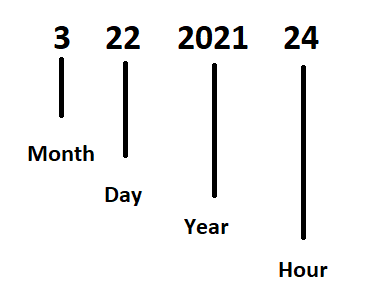

In [ ]:
time_series_data.convert_date_to_suitable_format()
time_series_data.display_samples()

,TRAVEL DATE,MONTH,WEEK,DAY,HOUR,FLIGHT,CUSTOMER TYPE,PRODUCT TYPE,NUMBER OF BOOKING
668,19-03-2021 12,MAR,3,TUESDAY,12,FD102,BUSINESS TRAVEL,ECONOMY,67
324,10-02-2021 06,FEB,2,SUNDAY,6,FD102,BUSINESS TRAVEL,BUSINESS CLASS,10
624,15-03-2021 24,MAR,2,FRIDAY,24,FD101,BUSINESS TRAVEL,FIRST CLASS,8
690,22-03-2021 24,MAR,3,FRIDAY,24,FD101,FIRST TIME FLYER,FIRST CLASS,6
473,26-02-2021 12,FEB,4,TUESDAY,12,FD101,FREQUENT FLYER,ECONOMY PLUS,37
204,24-01-2021 06,JAN,4,SUNDAY,6,FD102,BUSINESS TRAVEL,ECONOMY,50
97,14-01-2021 18,JAN,2,THURSDAY,18,FD101,FREQUENT FLYER,FIRST CLASS,13
336,12-02-2021 12,FEB,2,TUESDAY,12,FD101,BUSINESS TRAVEL,FIRST CLASS,11
568,08-03-2021 24,MAR,1,FRIDAY,24,FD101,BUSINESS TRAVEL,ECONOMY PLUS,32
148,19-01-2021 12,JAN,3,TUESDAY,12,FD102,BUSINESS TRAVEL,BUSINESS CLASS,12


Values in the columns 'HOUR' and 'MONTH' are also present in the column 'TRAVEL DATE'. So dropping 'HOUR' and 'MONTH' features as they contain only redundant information.

In [ ]:
time_series_data.drop_columns(['MONTH', ' HOUR'])
time_series_data.display_samples()

,TRAVEL DATE,WEEK,DAY,FLIGHT,CUSTOMER TYPE,PRODUCT TYPE,NUMBER OF BOOKING
668,19-03-2021 12,3,TUESDAY,FD102,BUSINESS TRAVEL,ECONOMY,67
324,10-02-2021 06,2,SUNDAY,FD102,BUSINESS TRAVEL,BUSINESS CLASS,10
624,15-03-2021 24,2,FRIDAY,FD101,BUSINESS TRAVEL,FIRST CLASS,8
690,22-03-2021 24,3,FRIDAY,FD101,FIRST TIME FLYER,FIRST CLASS,6
473,26-02-2021 12,4,TUESDAY,FD101,FREQUENT FLYER,ECONOMY PLUS,37
204,24-01-2021 06,4,SUNDAY,FD102,BUSINESS TRAVEL,ECONOMY,50
97,14-01-2021 18,2,THURSDAY,FD101,FREQUENT FLYER,FIRST CLASS,13
336,12-02-2021 12,2,TUESDAY,FD101,BUSINESS TRAVEL,FIRST CLASS,11
568,08-03-2021 24,1,FRIDAY,FD101,BUSINESS TRAVEL,ECONOMY PLUS,32
148,19-01-2021 12,3,TUESDAY,FD102,BUSINESS TRAVEL,BUSINESS CLASS,12


## Encoding

### Customer Type

Converting the categorical column 'CUSTOMER TYPE' to ordinal values.

Ordinality Considered :
- 'BUSINESS TRAVEL' : 4
- 'FREQUENT FLYER' : 3
- 'FIRST TIME FLYER' : 1
- 'RARE FLYER' : 2

In [ ]:
time_series_data.encode_customer_type()
time_series_data.display_samples()

,TRAVEL DATE,WEEK,DAY,FLIGHT,CUSTOMER TYPE,PRODUCT TYPE,NUMBER OF BOOKING
668,19-03-2021 12,3,TUESDAY,FD102,4,ECONOMY,67
324,10-02-2021 06,2,SUNDAY,FD102,4,BUSINESS CLASS,10
624,15-03-2021 24,2,FRIDAY,FD101,4,FIRST CLASS,8
690,22-03-2021 24,3,FRIDAY,FD101,1,FIRST CLASS,6
473,26-02-2021 12,4,TUESDAY,FD101,3,ECONOMY PLUS,37
204,24-01-2021 06,4,SUNDAY,FD102,4,ECONOMY,50
97,14-01-2021 18,2,THURSDAY,FD101,3,FIRST CLASS,13
336,12-02-2021 12,2,TUESDAY,FD101,4,FIRST CLASS,11
568,08-03-2021 24,1,FRIDAY,FD101,4,ECONOMY PLUS,32
148,19-01-2021 12,3,TUESDAY,FD102,4,BUSINESS CLASS,12


### Product Type

Converting the categorical column 'PRODUCT TYPE' to ordinal values.

Ordinality Considered :
- 'FIRST CLASS' : 4
- 'BUSINESS CLASS' : 3
- 'ECONOMY PLUS' : 1
- 'ECONOMY' : 2

In [ ]:
time_series_data.encode_product_type()
time_series_data.display_samples()

,TRAVEL DATE,WEEK,DAY,FLIGHT,CUSTOMER TYPE,PRODUCT TYPE,NUMBER OF BOOKING
668,19-03-2021 12,3,TUESDAY,FD102,4,1,67
324,10-02-2021 06,2,SUNDAY,FD102,4,3,10
624,15-03-2021 24,2,FRIDAY,FD101,4,4,8
690,22-03-2021 24,3,FRIDAY,FD101,1,4,6
473,26-02-2021 12,4,TUESDAY,FD101,3,2,37
204,24-01-2021 06,4,SUNDAY,FD102,4,1,50
97,14-01-2021 18,2,THURSDAY,FD101,3,4,13
336,12-02-2021 12,2,TUESDAY,FD101,4,4,11
568,08-03-2021 24,1,FRIDAY,FD101,4,2,32
148,19-01-2021 12,3,TUESDAY,FD102,4,3,12


### Flight

Encoding 'FLIGHT' column using one hot encoding.

In [ ]:
time_series_data.encode_flight_column()
time_series_data.display_samples()

,TRAVEL DATE,WEEK,DAY,CUSTOMER TYPE,PRODUCT TYPE,NUMBER OF BOOKING,FD101,FD102
668,19-03-2021 12,3,TUESDAY,4,1,67,0.0,1.0
324,10-02-2021 06,2,SUNDAY,4,3,10,0.0,1.0
624,15-03-2021 24,2,FRIDAY,4,4,8,1.0,0.0
690,22-03-2021 24,3,FRIDAY,1,4,6,1.0,0.0
473,26-02-2021 12,4,TUESDAY,3,2,37,1.0,0.0
204,24-01-2021 06,4,SUNDAY,4,1,50,0.0,1.0
97,14-01-2021 18,2,THURSDAY,3,4,13,1.0,0.0
336,12-02-2021 12,2,TUESDAY,4,4,11,1.0,0.0
568,08-03-2021 24,1,FRIDAY,4,2,32,1.0,0.0
148,19-01-2021 12,3,TUESDAY,4,3,12,0.0,1.0


### DAY

Encoding 'DAY' column using one hot encoding.

In [ ]:
time_series_data.day_encoding()
time_series_data.display_samples()

,TRAVEL DATE,WEEK,CUSTOMER TYPE,PRODUCT TYPE,NUMBER OF BOOKING,FD101,FD102,FRIDAY,SUNDAY,THURSDAY,TUESDAY
668,19-03-2021 12,3,4,1,67,0.0,1.0,0.0,0.0,0.0,1.0
324,10-02-2021 06,2,4,3,10,0.0,1.0,0.0,1.0,0.0,0.0
624,15-03-2021 24,2,4,4,8,1.0,0.0,1.0,0.0,0.0,0.0
690,22-03-2021 24,3,1,4,6,1.0,0.0,1.0,0.0,0.0,0.0
473,26-02-2021 12,4,3,2,37,1.0,0.0,0.0,0.0,0.0,1.0
204,24-01-2021 06,4,4,1,50,0.0,1.0,0.0,1.0,0.0,0.0
97,14-01-2021 18,2,3,4,13,1.0,0.0,0.0,0.0,1.0,0.0
336,12-02-2021 12,2,4,4,11,1.0,0.0,0.0,0.0,0.0,1.0
568,08-03-2021 24,1,4,2,32,1.0,0.0,1.0,0.0,0.0,0.0
148,19-01-2021 12,3,4,3,12,0.0,1.0,0.0,0.0,0.0,1.0


# Stationarity Analysis

## Graphical

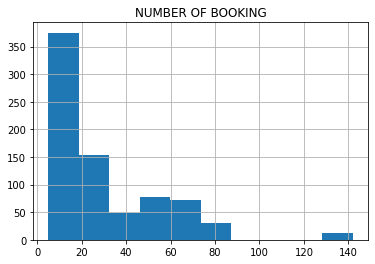

In [ ]:
time_series_data.graphical_analysis()

Splitting the time series data into two contiguous sequence and calculating mean and variance to compare the means and variances of the two sequence.

In [ ]:
time_series_data.mean_variance_stationary_analysis()

Mean : 29.1875 29.1875
Variance : 641.1263020833334 661.4283854166666


## Rolling Statistics Test

This method gives a visual representation of the data to define its stationarity. A Moving variance or moving average graph is plotted and then it is observed whether it varies with time or not.

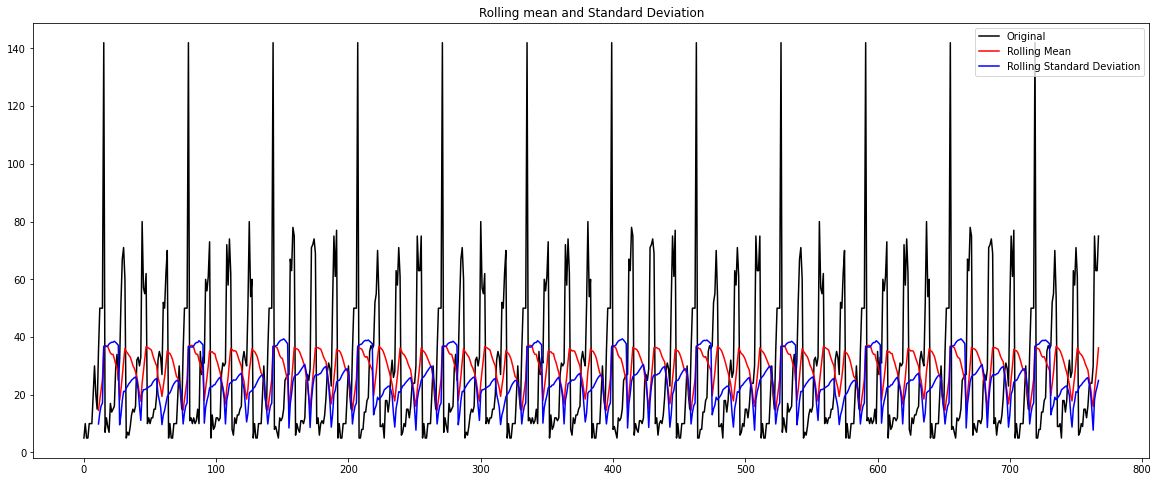

In [ ]:
time_series_data.rolling_statistics_test()

The graph of rolling mean and rolling standard deviation is constant, this shows that the dataset is stationary.

## Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller test is one of the more widely used type of statistical test (called a unit root test) that it determines how strongly a time series is defined by a trend.

- The **null hypothesis** of the test is that it is **not stationary** (has some time-dependent structure). The **alternate hypothesis** (rejecting the null hypothesis) is that the time series is **stationary.**

We interpret this result using the p-value from the test.
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data is stationary.

In [ ]:
time_series_data.augmented_dickey_fuller_test()

ADF Statistic: -8.522532823917018
p-value: 1.09086560005099e-13
Critial Values:
   1%, -3.43912257105195
Critial Values:
   5%, -2.8654117005229844
Critial Values:
   10%, -2.568831705010152


We can see that our statistic value of **-8.522** is less than the value of -3.44 at 1%. This suggests that we can **reject the null hypothesis** with a significance level of less than 1%.

Rejecting the null hypothesis means that the **time series is stationary or does not have time-dependent structure.**

## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

If p-value < 0.05, then the series is non-stationary.

- Null Hypothesis (HO): Series is trend stationary.
- Alternate Hypothesis(HA): Series is non-stationary.

**Note: Hypothesis is reversed in KPSS test compared to ADF Test.**

If the null hypothesis is failed to be rejected, this test may provide evidence that the series is trend stationary.

In [ ]:
time_series_data.kwiatkowski_phillips_schmidt_shin_test()

Results of KPSS Test:
Test Statistic           0.012779
p-value                  0.100000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2016: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


The p-value 0.1 is > 0.05, which **doesn't fail to reject null hypothesis.**
Therefore, the data is **stationary.**

## Zivot-Andrews Test

In [ ]:
time_series_data.zivot_andrews_test()

Zivot-Andrews Statistic: -8.57
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary


Since p-value <= 0.05, it is a stationary data.

**Since all three tests ADF, KPSS and Zivot-Andrews tests conclude that the data is stationary, the given series is concluded to be in stationary.**